<a href="https://colab.research.google.com/github/kabirodavies/Unsupervised-Learning-Recommender-Application/blob/main/movierecomendernotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="top"></a>
# Predict Notebook
### Kaggle Submission: Team 3
---


### Table of Contents
---
1. [Introduction](#intro)
 * Background Infornation

---
2. [Connecting to Comet](#Comet)
 * Loading colaborating tool
 ---
3. [Load Dependencies](#imports)
 * Imports
 
---
4. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Missing Values
 * Ratings
 * Genres
 * IMDB Metadata
---
5. [Data Preprocessing](#preprocessing)
 * Multidimensional Scaling
 * Principle Component Analysis
 * Cluster Analysis
---
6. [Modelling](#modelling)
 * Collaborative Filtering
 * Content-based Filtering
---
7. [Performance Evaluation](#evaluation)
 * Root Mean Squared Error (RMSE)
 * Cross Validation
---
8. [Model Analysis](#analysis)
 * Hyperparameter Tuning
 * Results
---
9. [Conclusion](#conclusion)
---
10. [Save Output](#ref)
---
11. [References](#save)
--- 

<a id="intro"></a>
## 1. Introduction  

### Background

Movie recommender systems are very critical in  ensuring movie lovers can easily get  a glimpse of what type of movie content they engage with daily.



Current recommendation systems are content-based filtering and collaborative  filtering

#### Content-based filtering

This makes recommendations based on user preferences for product features. It is able to recommend new items, but is limited by the need for more data of user preference to improve the quality of recommendations.

#### Collaborative filtering

Collaborative filtering mimics user-to-user recommendations.

#### Hybrid systems

A combination of these two recommendations systems is called a hybrid system. They mix the features of the item itself and the preferences of other users

### Problem Statement
Construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

<a id="imports"></a>
## 2. Connecting to Comet

Loading Comet

In [4]:
! pip install comet_ml

     |████████████████████████████████| 315 kB 20.7 MB/s 
     |████████████████████████████████| 418 kB 50.2 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
  Created wheel for dulwich: filename=dulwich-0.20.31-cp37-cp37m-linux_x86_64.whl size=529916 sha256=d12d09f5e08f96fa1f26af1f69d3d970d894ec4095f3a95911c486e870d3d0a4
  Stored in directory: /root/.cache/pip/wheels/2a/91/4b/baf2db7868260b018efce675f252fc0ae4c09b28c652df9736
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=295672a8fe3cf9c42cf514aff2bb753039e5c6585a37f18e4b999767cb086f22
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built dulwich configobj


In [5]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="WmgZTL21HXdupUnj1OYJH2nw8",
    project_name="movie-recomendations",
    workspace="hassan1a",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hassan1a/movie-recomendations/5a2fc2709d034bd9b98e5308b5150a45



### Libriaries

In [8]:
# ! pip install surprise

In [9]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
import random
from time import time
import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Models
from surprise import Reader, Dataset
from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)

### Data

In [11]:
#Kaggle setup
! pip install -q kaggle

from google.colab import  files
files.upload()

#Create Kaggle Folder
!mkdir ~/.kaggle
#Copy Kaggle.json file to new folder
! cp kaggle.json ~/.kaggle/
#Grant Permissions
! chmod 600  ~/.kaggle/kaggle.json
#Datasets List
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
yamqwe/omicron-covid19-variant-daily-cases                  Omicron daily cases by country (COVID-19 variant)  432KB  2022-01-24 05:35:45           7413  
nkitgupta/jigsaw-regression-based-data                      Jigsaw Regression Based Data                         3GB  2022-01-10 06:29:59            445  
prasertk/netflix-subscription-price-in-different-countries  Netflix subscription fee in different countries      3KB  2022-01-15 07:06:09            695  
yasserh/song-popularity-dataset                             Song Popularity Dataset                            805KB  2022-01-07 13:18:43           1048  
vishalmane10/anime-dataset-2022     

In [12]:
#Download dataset
! kaggle competitions download -c 'edsa-movie-recommendation-wilderness'

  0% 0.00/2.26M [00:00<?, ?B/s]
100% 2.26M/2.26M [00:00<00:00, 76.8MB/s]
 89% 101M/113M [00:00<00:00, 118MB/s] 
100% 113M/113M [00:01<00:00, 111MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 30.8MB/s]
 59% 6.00M/10.1M [00:00<00:00, 61.2MB/s]
100% 10.1M/10.1M [00:00<00:00, 64.3MB/s]
 78% 12.0M/15.3M [00:00<00:00, 60.5MB/s]
100% 15.3M/15.3M [00:00<00:00, 59.8MB/s]
 33% 5.00M/15.0M [00:00<00:00, 45.6MB/s]
100% 15.0M/15.0M [00:00<00:00, 73.4MB/s]
  0% 0.00/577k [00:00<?, ?B/s]
100% 577k/577k [00:00<00:00, 37.5MB/s]
 90% 74.0M/81.9M [00:01<00:00, 61.7MB/s]
100% 81.9M/81.9M [00:01<00:00, 73.5MB/s]
  0% 0.00/17.7k [00:00<?, ?B/s]
100% 17.7k/17.7k [00:00<00:00, 24.8MB/s]


In [13]:
#Unzip datasets
! mkdir datasets
!unzip movies.csv.zip -d datasets
!unzip train.csv.zip -d datasets
!unzip test.csv.zip -d datasets
!unzip tags.csv.zip -d datasets
!unzip links.csv.zip -d datasets
!unzip imdb_data.csv.zip -d datasets
!unzip genome_scores.csv.zip -d datasets
!unzip sample_submission.csv.zip -d datasets


Archive:  movies.csv.zip
  inflating: datasets/movies.csv     
Archive:  train.csv.zip
  inflating: datasets/train.csv      
Archive:  test.csv.zip
  inflating: datasets/test.csv       
Archive:  tags.csv.zip
  inflating: datasets/tags.csv       
Archive:  links.csv.zip
  inflating: datasets/links.csv      
Archive:  imdb_data.csv.zip
  inflating: datasets/imdb_data.csv  
Archive:  genome_scores.csv.zip
  inflating: datasets/genome_scores.csv  
Archive:  sample_submission.csv.zip
  inflating: datasets/sample_submission.csv  


#### Train and test data:

In [16]:
# import dataset
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
print(train_df.shape, test_df.shape)
train_df.head(3)

(10000038, 4) (5000019, 2)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


In [17]:
# train_df = pd.read_csv('/movies-recomendation/train.csv')
# test_df = pd.read_csv('/movies-recomendation/test.csv')
# print(train_df.shape, test_df.shape)
# train_df.head(3)

It is noted that the train data includes an additiona column "timestamp" This data can be safely dropped as there is no reasonable link between the time someone watches a movie and whether or not they rate it favourably.

#### Movie Data:

In [ ]:
movies_df =  pd.read_csv('/movies-recomendation/movies.csv', index_col='movieId')
imdb_df =  pd.read_csv('/movies-recomendation/imdb_data.csv', index_col='movieId')
links_df =  pd.read_csv('/movies-recomendation/links.csv', index_col='movieId')
genome_scores =  pd.read_csv('/movies-recomendation/genome_scores.csv', index_col='movieId')
genome_tags =  pd.read_csv('/movies-recomendation/genome_tags.csv', index_col='tagId')
print(movies_df.shape, imdb_df.shape, links_df.shape, genome_scores.shape, genome_tags.shape)

(62423, 2) (27278, 5) (62423, 2) (15584448, 2) (1128, 1)


In [19]:
# tags = pd.read_csv('datasets/tags.csv')
movies_df = pd.read_csv('datasets/movies.csv')
imdb_df = pd.read_csv('datasets/imdb_data.csv')
links_df = pd.read_csv('datasets/links.csv')
genome_tags = pd.read_csv('genome_tags.csv')
genome_scores = pd.read_csv('datasets/genome_scores.csv')
# sample_submission = pd.read_csv('datasets/sample_submission.csv')
print(movies_df.shape, imdb_df.shape, links_df.shape, genome_scores.shape, genome_tags.shape)

(62423, 3) (27278, 6) (62423, 3) (15584448, 3) (1128, 2)


<a id="EDA"></a>
## 3. Exploratory Data Analysis

### Data Summary

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [47]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [48]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [49]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62316 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62316 non-null  int64  
 1   imdbId   62316 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.9 MB


In [50]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


In [51]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


### Missing Values

In [52]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("************")
print("Test: ")
print(str(test_df.isnull().sum()))
print("************")
print("Movies: ")
print(str(movies_df.isnull().sum()))
print("************")
print("Links: ")
print(str(links_df.isnull().sum()))
print("************")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("************")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("************")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
************
Test: 
userId     0
movieId    0
dtype: int64
************
Movies: 
movieId    0
title      0
genres     0
dtype: int64
************
Links: 
movieId    0
imdbId     0
tmdbId     0
dtype: int64
************
IMDB: 
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
************
Genome scores: 
movieId      0
tagId        0
relevance    0
dtype: int64
************
Genome tags: 
tagId    0
tag      0
dtype: int64


In [53]:
# Drop missing rows

links_df.dropna(axis=0,inplace=True)

### Ratings

Q: Which users have rated the most movies?

In [54]:
def user_ratings_count(df, n):
    """
    Counts the number of user ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        n (int): number of users to show
    Returns
    -------
        barplot (NoneType): barplot of top n users by number of observations
    Example
    -------
        >>> df = pd.DataFrame({'userId':[1,2,3,1,2,4,5,4]})
        >>> user_ratings_count(df, 3)
            NoneType (barplot)
    """
    plt.figure(figsize=(8,6))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='brg', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 34398 
Total number of movies:		 48213


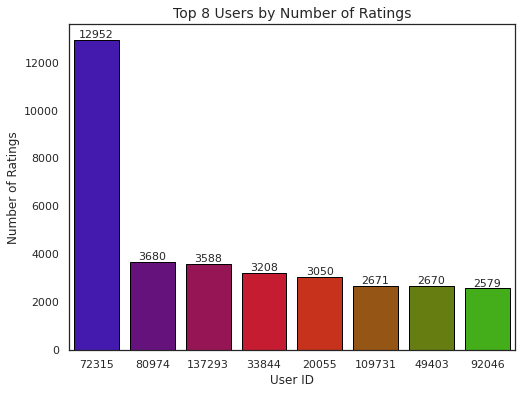

In [55]:
user_ratings_count(train_df,8)

Fig 1. User 72315 has rated an extreme number of movies relative to other users. For EDA purposes, this user is removed to make interpretation easier.

In [56]:
# Exclude user 72315 for EDA
eda_df = train_df[train_df['userId']!=72315]

Combined number of ratings:	 23734 
Total number of movies:		 45844


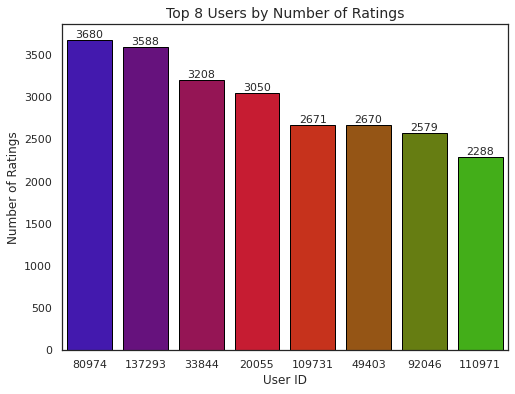

In [57]:
user_ratings_count(eda_df,8)

In [58]:
# How many ratings have we lost?
34398-23734

10664

In [59]:
# How many movies were only rated by our outlier?
48213-45844

2369

Our outlier user clearly rated quite a few movies. The loss of unique ratings indicates that he could've been the only person watching those movies. This would cause the recommender to use him as a baseline for those movies.

Q: How do users tend to rate movies?

In [60]:
def ratings_distplot(df, column='rating'):
    """
    Plots the distribution of ratings in the dataset.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        column (str): column to plot
    Returns
    -------
        distplot (NoneType): distplot of rating frequencies
    """
    plt.figure(figsize=(8,6))
    ax = sns.distplot(df[f'{column}'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="#4D17A0")
    mean = df[f'{column}'].mean()
    median = df[f'{column}'].median()
    plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#4D17A0', lw=3, ls = '--')
    plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
    plt.xlim((0.5,5))
    plt.ylim((0,2500000))
    plt.title(f'Distribution of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

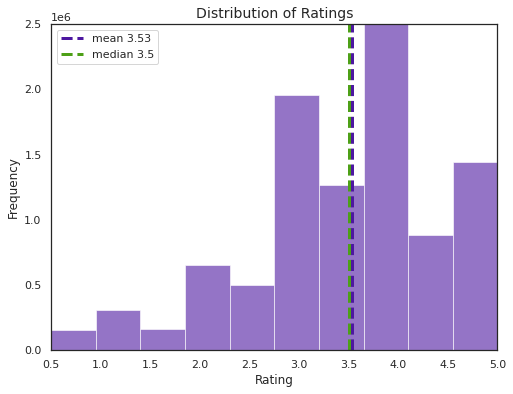

In [61]:
ratings_distplot(eda_df)

It is interesting that the ratings are left-skewed. It was expected that there would be a normal distrubtion with a mean rating of 3. Instead, we observe that users tend to rate movies quite favourably and tend to avoid negative ratings. This skew might be explained by the tendency of users to rate movies they liked. In other words, if a user doesn't like a movie, it is unlikely that they will watch it through to the end, let alone rate it.

Q: Is there a relationship between the number of movies a user has rated and the rating that they give?

In [62]:
def mean_ratings_scatter(df, color='#4DA017', column='userId'):
    """
    Make scatterplots of mean ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        color (str): plot colour
        column (str): column to plot
    Returns
    -------
        scatterplot (NoneType): scatterplot of mean number of ratings
    """
    plt.figure(figsize=(6,4))
    mean_ratings = df.groupby(f'{column}')['rating'].mean()
    user_counts = df.groupby(f'{column}')['movieId'].count().values
    sns.scatterplot(x=mean_ratings, y = user_counts, color=color)
    plt.title(f'Mean Ratings by Number of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Number of Ratings')
    plt.show()

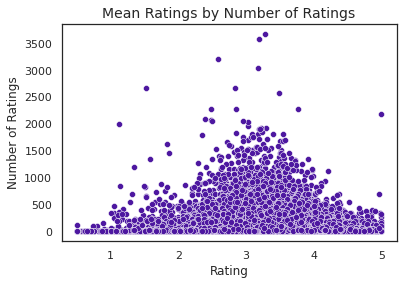

In [63]:
# Mean user ratings by number of ratings
mean_ratings_scatter(eda_df,'#4D17A0')

There doesn't seem to be a relationship, as the number of ratings and how a user rates a movie do not show any correlation.

Q: Is there a relationship between the number of ratings a movie has and how highly it is rated?

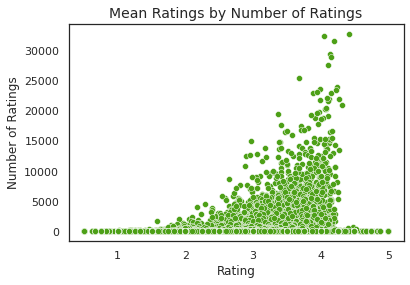

In [64]:
# Mean movie ratings by number of ratings
mean_ratings_scatter(eda_df, column='movieId')

This time we do see a relationship, The more ratings a movie has, the more highly it is likely to be rated. This confirms our intuitive understanding that the more highly rated a movie is, the more likely is that viewers will recommend the movie to each other. In other words, people generally try to avoid maing bad recommendations

Q: Which are the best and worst rated movies of all time?

In [65]:
def plot_ratings(count, n, color='#4DA017', best=True, method='mean'):
    """
    Make scatterplots of ratings.
    Parameters
    ----------
        count (int): number of ratings threshold
        n (int): number of movies
        color (str): plot colour
        best (bool): column to plot
        method (str): statistical measure
    Returns
    -------
        scatterplot (NoneType): scatterplot of mean number of ratings
    """
    # What are the best and worst movies
    # Creating a new DF with mean and count
    if method == 'mean':
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].mean())
    else:
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].median())
    movie_avg_ratings['count'] = eda_df.groupby('movieId')['userId'].count().values
    movie_avg_ratings.reset_index(inplace=True)
    movie_avg_ratings.set_index('movieId', inplace=True)

    # Remove movies that have been rated fewer than n times
    data = movie_avg_ratings[movie_avg_ratings['count']>count]
    data.sort_values('rating', inplace= True,ascending=False)
    if best == True:
        plot = data.head(n).sort_values('rating', ascending=True)
        title='Best Rated'
    else:
        plot = data.tail(n).sort_values('rating', ascending=False)
        title='Worst Rated'
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=plot['rating'], y=plot['title'], size=plot['count'], color=color)
    plt.xlabel('Rating')
    plt.ylabel('')
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    plt.title(f'Top {n} {title} Movies with Over {count} Ratings', fontsize=14)
    plt.show()

In [66]:
# What are the top 10 highest rated titles?
plot_ratings(10000, 15, '#4D17A0', True, 'mean')

ValueError: ignored

By filtering movies with less than 10000 ratings, we find that the most popular movies are unsurprising titles. The Shawshank Redemption and The Godfather unsurprisingly top the list. What is interesting is that Movies made post 2000 don't feature often. Do users have a preference to Older movies?

In [ ]:
# What are the 10 worst rated titles?
plot_ratings(500, 15,'#4DA017', False, 'mean')

Obviously, people did not like Battlefield too much and with 1200 ratings, they really wanted it to be known. It is interesting how many sequels appear in the list

In [ ]:
movieRatingDistGroup = train_df['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="brg", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

Percentage of users per rating, most movies get a rating of 4.0.

### Genres

In [ ]:
# function that hasn't found a use yet - it was usefull in the app!!
def feat_extractor(df, col):
    """
    Returns a list of all unique features in a DataFrame columns separated by "|"
    """
    df.fillna("", inplace=True)
    feat_set = set()
    for i in range(len(df[f'{col}'])):
        for feat in df[f'{col}'].iloc[i].split('|'):
            feat_set.add(feat)
    return sorted([feat for feat in feat_set if feat != ""])

In [ ]:
genres = feat_extractor(movies_df, 'genres')

Q: Which genres are the most commonly observed?

In [ ]:
def feature_frequency(df, column):
    """
    Function to count the number of occurences of metadata such as genre
    Parameters
    ----------
        df (DataFrame): input DataFrame containing movie metadata
        column (str): target column to extract features from
    Returns
    -------
        
    """
    # Creat a dict to store values
    df = df.dropna(axis=0)
    genre_dict = {f'{column}': list(),
                 'count': list(),}
    # Retrieve a list of all possible genres
    print('retrieving features...')
    for movie in range(len(df)):
        gens = df[f'{column}'].iloc[movie].split('|')
        for gen in gens:
            if gen not in genre_dict[f'{column}']:
                genre_dict[f'{column}'].append(gen)
    # count the number of occurences of each genre
    print('counting...')
    for genre in genre_dict[f'{column}']:
        count = 0
        for movie in range(len(df)):
            gens = df[f'{column}'].iloc[movie].split('|')
            if genre in gens:
                count += 1
        genre_dict['count'].append(count)
        
        # Calculate metrics
    data = pd.DataFrame(genre_dict)
    print('done!')
    return data
genres = feature_frequency(movies_df, 'genres')

In [ ]:
def feature_count(df, column):
    plt.figure(figsize=(10,6))
    ax = sns.barplot(y = df[f'{column}'], x = df['count'], palette='brg', orient='h')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.ylabel(f'{column}')
    plt.xlabel('Count')
    plt.show()

In [ ]:
feature_count(genres.sort_values(by = 'count', ascending=False), 'genres')

Drama is the most frequently occuring genre in the database. Approximately 5000 movies have missing genres. We can use the IMDB and TMDB ID's together with the APIs to fill missing data. Further, IMAX is not a genre but rather a proprietary system for mass-viewings.

The above figure does not tell us anything about the popularity of the genres, lets calculate a mean rating and append it to the data

In [ ]:
def mean_calc(feat_df, ratings = eda_df, movies = movies_df, metadata = imdb_df, column = 'genres'):
    mean_ratings = pd.DataFrame(ratings.join(movies, on='movieId', how='left').groupby(['movieId'])['rating'].mean())
    movie_eda = movies.copy()
    movie_eda = movie_eda.join(mean_ratings, on = 'movieId', how = 'left')

    # Exclude missing values
    movie_eda = movie_eda
    movie_eda2 = movie_eda[movie_eda['rating'].notnull()]

    means = []
    for feat in feat_df[f'{column}']:
        mean = round(movie_eda2[movie_eda2[f'{column}'].str.contains(feat)]['rating'].mean(),2)
        means.append(mean)
    return means

In [ ]:
genres['mean_rating'] = mean_calc(genres)

In [ ]:
genres.sort_values('mean_rating', ascending=False).head(5)

Film-Noir describes Hollywood crime dramas, particularly those that emphasize cynical attitudes and sexual motivations. The 1940s and 1950s are generally regarded as the "classic period" of American film-noir. These movies have the highest ratings but this may be as a result of it's niche audence. The same logic can be applied to IMAX movies, as such, we will only include genres with a count of 500 or more.

In [ ]:
def genre_popularity(df):
    """
    Plots the mean rating per genre.
    """
    count_filt = 500
    plt.figure(figsize=(10,6))
    plot_data = df[df['count']>count_filt]
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = plot_data['mean_rating'].max()
    sns.barplot(y = plot_data['genres'], x = plot_data['mean_rating'], order = plot_data['genres'], orient='h',palette='brg')
    plt.axvline(x=mean, label = f'mean {round(mean,1)}' , color='black', lw=1, ls ='--')
    plt.axvline(x=min_, label = f'min {round(min_,1)}' , color='#4D17A0', lw=1, ls = '--')
    plt.axvline(x=max_, label = f'max {max_}' , color='#4DA017', lw=1,ls = '--')
    plt.title(f'Mean Rating Per Genre', fontsize=14)
    plt.ylabel('Genre')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

In [ ]:
genre_popularity(genres.sort_values('mean_rating', ascending=False))

The scores are almost evenly distributed with the exceptions of Documentaries, War, Drama, Musicals, and Romance and Thriller, Action, Sci-Fi, and Horror, which rate higher than average and far below average respectively.  

We can also visualuse the distribution of ratings per genre with a boxplot.

In [ ]:
box = mean_ratings.join(movies_df)
box['genres'] = box['genres'].str.replace('|', ',')
box['genres'] = box['genres'].apply(lambda x: x.split(","))
box = box.explode('genres')
box = box[box['genres']!='(no genres listed)']

fig,axis = plt.subplots(figsize=(10, 8))
sns.boxplot(y=box['genres'], x=box['rating'], palette="brg", orient='h', showfliers = False)
plt.title("Distribution of Ratings Per Genre", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Genre")
plt.show()

### IMDB Metadata

#### Directors

Q: Who are the most common directors?

In [ ]:
def count_directors(df, count = 10):
    """
    Function to count the most common dircetors in a DataFrame:
    Parameters
    ----------
        df (DataFrame): input dataframe containing imdb metadata
        count (int): filter directors with fewer than count films
        
    Returns
    -------
        directors (DataFrame): output DataFrame
    Examples
    --------
        >>> df = pd.DataFrame({'imdbid':[0,1,2,3,4,5], 'director': [A,B,A,C,B]})
        >>> count_directors(df, count = 1)
            |index|director|count|
            |0|A|2|
            |1|B|2|
            |2|C|1|
    """
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    # Lets only take directors who have made 10 or more movies otherwise we will have to analyze 11000 directors
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)
directors = count_directors(imdb_df)

Some movies do not have a director listed. once again, the IMDB API can be used to retrieve this data

In [ ]:
feature_count(directors.head(10), 'director')

Once again we need to calculate a mean rating for each director in order to determine who is the most popular

In [ ]:
def dir_mean(df):
    df.set_index('director', inplace=True)

    direct_ratings = []
    directors_eda = eda_df.join(imdb_df, on = 'movieId', how = 'left')
    for director in df.index:
        rating = round(directors_eda[directors_eda['director']==director]['rating'].mean(),2)
        direct_ratings.append(rating)
    df['mean_rating'] = direct_ratings
    return df.sort_values('mean_rating', ascending = False)

In [ ]:
directors = dir_mean(directors)

In [ ]:
directors.head()

In [ ]:
def feat_popularity(df, title = 'feat'):
    """
    Plots the mean rating per director.
    """
    plt.figure(figsize=(10,6))
    plot_data = df.copy()
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = round(plot_data['mean_rating'].max(),2)
    sns.barplot(y = plot_data.index, x = plot_data['mean_rating'], order = plot_data.index, orient='h',palette='brg')
    plt.axvline(x=mean, label = f'mean {round(mean,1)}' , color='black', lw=1, ls ='--')
    plt.axvline(x=min_, label = f'min {round(min_,1)}' , color='#4D17A0', lw=1, ls = '--')
    plt.axvline(x=max_, label = f'max {max_}' , color='#4DA017', lw=1,ls = '--')
    plt.title(f'Mean Rating Per {title}', fontsize=14)
    plt.ylabel(f'{title}')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

In [ ]:
feat_popularity(directors.head(10), 'Director')

Immediately, we see some very well known names, Stephen King and Quentin Tarantino are unsurprisingly top of the list. It begs the question, who are the worst rated directors?

In [ ]:
feat_popularity(directors.tail(10), 'Director')

It is unfortunate to find Tyler Perry and Akira Toriyama so poorly rated. Tyler Perry is best known for his Madea series of movies. As we saw from the least popular movies, sequels do not perform well and Madea has numerous sequels.

Akira Toriyama is the Manga artist behind the Dragon Ball franchise. Dragonball is important to Anime communities because it popularized anime in the west. However, despite its loyal fan base, it remains far from being the best anime.

<a id="preprocessing"></a>
## 4. Data Preprocessing

### Multidimensional Scaling
Multidimensional scaling (MDS) is a technique for visualizing distances between objects on a map, where the distance is known between pairs of the objects.  


In [67]:
# Subset the data to cut down computation time for now
genome_score = genome_scores[:10000000]

In [68]:
# Although scores are in the range of 0-1, there is no harm in scaling
scaler_mds = StandardScaler()
mds_genome = scaler_mds.fit_transform(genome_score.sample(frac=0.0001))

In [69]:
tsne = TSNE(3, n_jobs = -1, verbose = 2, perplexity = 10, learning_rate = 0.1)

In [70]:
tsne.fit(mds_genome)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.126233
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 84.2639542, gradient norm = 0.0000258 (50 iterations in 1.141s)
[t-SNE] Iteration 100: error = 84.2639542, gradient norm = 0.0000035 (50 iterations in 1.036s)
[t-SNE] Iteration 150: error = 84.2639542, gradient norm = 0.0000027 (50 iterations in 0.873s)
[t-SNE] Iteration 200: error = 84.2639542, gradient norm = 0.0000050 (50 iterations in 0.768s)
[t-SNE] Iteration 250: error = 84.2639542, gradient norm = 0.0000122 (50 iterations in 0.678s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.263954
[t-SNE] Iteration 300: error = 4.5370836, gradient norm = 0.0000224 (50 iterations in 0.674s)
[t-SNE] Iteration 350: error = 4.5370827, gradient norm = 0.00006

TSNE(learning_rate=0.1, n_components=3, n_jobs=-1, perplexity=10, verbose=2)

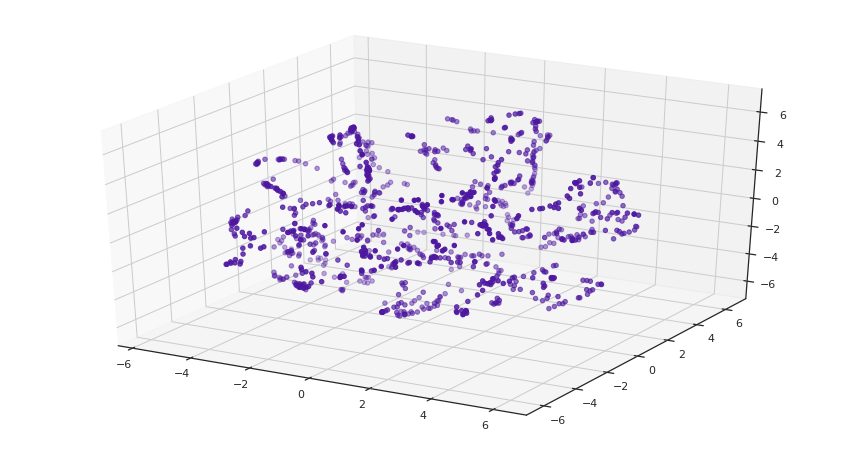

In [71]:
Axes3D

fig = plt.figure(figsize=(15, 8))

# Add 3D scatter plot
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], tsne.embedding_[:,2], color='#4D17A0')
plt.show()

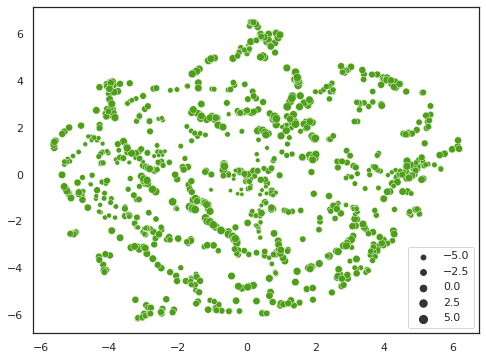

In [72]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsne.embedding_[:,0], y = tsne.embedding_[:,1], size=tsne.embedding_[:,2],color='#4DA017')
plt.show()

### Principal Component Analysis
Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance. [[4]](#ref4)

In [73]:
# Manually pivot table as data is too large for in-built functions
def pivot_(df):
    """
    Pivots table.
    """
    new_dict = {'movieId':sorted(set(df.index))}
    pivoted = pd.DataFrame(new_dict)
    tagids = sorted(set(df['tagId']))
    for Id in range(len(tagids)):
        pivoted[f'{Id+1}'] = list(df[df['tagId'] == Id+1]['relevance'])
    return pivoted

In [74]:
pca_data_pivoted = pivot_(genome_scores).set_index('movieId')

ValueError: ignored

In [ ]:
pca_data_pivoted.shape

Lets make this more readable

In [75]:
pca_data_pivoted.columns = list(genome_tags['tag'])

NameError: ignored

In [76]:
pca_data_pivoted.head()

NameError: ignored

In [ ]:
features = [col for col in pca_data_pivoted.columns]

#### Scales of measurement
It is important that we scale the data before dimensionality reduction.

Although all variables are measured on the same scale (0-1), there shouldn't be any downside to setting the mean to zero and standard deviation to 1

In [ ]:
cf.set_config_file(offline=True, world_readable=True, theme='white')
columns = random.sample(range(0, 1129), 20)
pca_data_pivoted.iloc[:,columns].iplot(kind='box', title="Boxplots of Features (Unscaled)")

In [ ]:
def scaler(df):
    """
    Scales data.
    """
    scaler = StandardScaler(with_std=True)
    scaled_data = scaler.fit_transform(df)
    return scaled_data

In [ ]:
pca_scaled = scaler(pca_data_pivoted)

In [ ]:
scaled_pca = pd.DataFrame(pca_scaled, index = pca_data_pivoted.index, columns = pca_data_pivoted.columns)

In [ ]:
cf.set_config_file(offline=True, world_readable=True, theme='white')
# using plotly to plot the boxplot
scaled_pca.iloc[:,columns].iplot(kind='box', title="Boxplots of Features (Scaled)")

In [ ]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(pca_data_pivoted[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp,
                      index=pca_data_pivoted.index, columns=pca_data_pivoted.columns
                     )

# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='#4D17A0')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
pca_75 = PCA(.80)
pca_75_df = pca_75.fit_transform(pca_data_pivoted)
print(round(pca_75.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_75.n_components_,
      "components.")

The cummulative explained variance shows an initially steep then gradual curve and not the sharp elbow we were expecting. This could be a result of the genomes already having been chosen as the principle components of movies. However we can see that 80% of the variance in the movie dataset is explained by 131 components. We should use only these components for computatonal efficiency in a content based model

In [ ]:
pca_75_df = pd.DataFrame(pca_75_df, index = pca_data_pivoted.index)
pca_75_df.head()

### Cluster Analysis

In [ ]:
# Manually implement the WCSS
def within_cluster_variation(df, label_col='cluster_label'):
    """
    Manually implements the WCSS.
    """
    centroids = df.groupby(label_col).mean()
    out = 0
    for label, point in centroids.iterrows():
        df_features = df[df[label_col] == label].drop(label_col, axis=1)
        out += (df_features - point).pow(2).sum(axis=1).sum()
    return out

In [ ]:
# let's try everything between 2 and 18 clusters where 18 is the number of genres
n_clusters = np.arange(2, 19)

# store errors for each value of k
errors = []

# for i between 2 and 19
for k in n_clusters:
    print(f'training model with {k} clusters')
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(pca_75_df)
    
    # measure BCSS
    print(f'evaluating model with {k} clusters')
    y_preds = km.predict(pca_75_df)
    pca_75_df = pd.DataFrame(pca_75_df)
    pca_75_df['cluster_label'] = y_preds
    errors.append(within_cluster_variation(pca_75_df, 'cluster_label'))
    print(errors[-1])

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors, color="#4DA017")
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.axvline(x=3, color='#4D17A0', lw=2)
plt.show()

In [ ]:
K = 3
# Remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(pca_75_df)
print("done in %0.3fs" % (time() - t0))

In [ ]:
# Obtain cluster memberships for each item in the data
y_preds = km.predict(pca_75_df)
pca_75_df['cluster_label'] = y_preds
centers = km.cluster_centers_

In [ ]:
plt.figure(dpi=120)
for k in range(K):
    x1 = pca_75_df[pca_75_df['cluster_label'] == k][0]
    x2 = pca_75_df[pca_75_df['cluster_label'] == k][1]
    plt.scatter(x1, x2, label="k = "+str(k+1),alpha=0.75)
# Show cluster centroid locations    
plt.scatter(centers[:,0],centers[:,1],label="centroid")
plt.legend()
plt.title(f"K = {K}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

<a id="modelling"></a>
## 5. Modelling

To reduce computation time, we train and evaluate the following models on a 100k subset of the data. The best performing model will be trained on the whole dataset to predict the ratings for the final submission file.

In [78]:
# Load the 100k dataset
train_df.drop('timestamp', axis=1, inplace=True)
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Collaborative Filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user [[5]](#ref5).

#### SVD

The Singular Value Decomposition algorithm is a matrix factorization technique which reduces the number of features of a dataset and was popularized by Simon Funk during the [Neflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest [[6]](#ref6). In the matrix structure, each row represents a user and each column represents a movie. The matrix elements are ratings that are given to movies by users.

In [79]:
svd_test = SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.9746


#### NormalPredictor  
The Normal Predictor algorithm predicts a random rating for each movie based on the distribution of the training set, which is assumed to be normal.

In [80]:
np_test = NormalPredictor()
np_test.fit(trainset)
predictions = np_test.test(testset)
# Calculate RMSE
np_rmse = accuracy.rmse(predictions)

RMSE: 1.4443


#### BaselineOnly  
The Baseline Only algorithm predicts the baseline estimate for a given user and movie. A baseline is calculated using either Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS).

In [81]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
blo_test.fit(trainset)
predictions = blo_test.test(testset)
# Calculate RMSE
blo_rmse = accuracy.rmse(predictions)

Estimating biases using sgd...
RMSE: 0.9735


#### NMF  
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

In [82]:
nmf_test = NMF()
nmf_test.fit(trainset)
predictions = nmf_test.test(testset)
# Calculate RMSE
nmf_rmse = accuracy.rmse(predictions)

RMSE: 1.1603


#### SlopeOne  
The SlopeOne algorithm is a simple yet accurate collaborative filtering algorithm that uses a simple linear regression model to solve the data sparisity problem. 

In [83]:
slo_test = SlopeOne()
slo_test.fit(trainset)
predictions = slo_test.test(testset)
# Calculate RMSE
slo_rmse = accuracy.rmse(predictions)

RMSE: 1.1598


#### CoClustering  
The Co-clustering algorithm assigns clusters using a straightforward optimization method, much like k-means.

In [84]:
cc_test = CoClustering(random_state=42)
cc_test.fit(trainset)
predictions = cc_test.test(testset)
# Calculate RMSE
cc_rmse = accuracy.rmse(predictions)

RMSE: 1.1514


### Content-based Filtering  
Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document [[7]](#ref7). In the following section, the model uses genres as keywords to recommend similar movies based on input from a user. The model was not used to predict ratings for the testing data, as it is too computationally expensive.

In [85]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.

    Parameters
    ----------
    subset_size : int
        Number of movies to use within the algorithm.

    Returns
    -------
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    # Split genre data into individual words.
    movies['keyWords'] = movies['genres'].str.replace('|', ' ')
    # Subset of the data
    movies_subset = movies[:subset_size]
    return movies_subset
 
def content_model(movie_list,top_n=10): 
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    data = data_preprocessing(2000)
    # Instantiating and generating the count matrix
    count_vec = CountVectorizer()
    count_matrix = count_vec.fit_transform(data['keyWords'])
    indices = pd.Series(data['title'])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    cosine_sim = pd.DataFrame(cosine_sim, index = data.index, columns = data.index)
    # Getting the index of the movie that matches the title
    idx_1 = indices[indices == movie_list[0]].index[0]
    idx_2 = indices[indices == movie_list[1]].index[0]
    idx_3 = indices[indices == movie_list[2]].index[0]
    # Creating a Series with the similarity scores in descending order
    rank_1 = cosine_sim[idx_1]
    rank_2 = cosine_sim[idx_2]
    rank_3 = cosine_sim[idx_3]
    # Calculating the scores
    score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
    score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
    score_series_3 = pd.Series(rank_3).sort_values(ascending = False)
    # Getting the indexes of the 10 most similar movies
    listings = score_series_1.append(score_series_2).append(score_series_3).sort_values(ascending = False)
    # Store movie names
    recommended_movies = []
    # Appending the names of movies
    top_50_indexes = list(listings.iloc[1:50].index)
    # Removing chosen movies
    top_indexes = np.setdiff1d(top_50_indexes,[idx_1,idx_2,idx_3])
    for i in top_indexes[:top_n]:
        recommended_movies.append(list(movies['title'])[i])
    return recommended_movies

In [86]:
movies = movies_df.dropna()
movie_list = ['Grumpier Old Men (1995)','Ace Ventura: When Nature Calls (1995)','Father of the Bride Part II (1995)']
content_model(movie_list,top_n=10)

['Ready to Wear (Pret-A-Porter) (1994)',
 'Rent-a-Kid (1995)',
 'Stuart Saves His Family (1995)',
 "National Lampoon's Senior Trip (1995)",
 'Tommy Boy (1995)',
 "Muriel's Wedding (1994)",
 'Ace Ventura: Pet Detective (1994)',
 'Airheads (1994)',
 'Air Up There, The (1994)',
 'Getting Even with Dad (1994)']

<a id="evaluation"></a>
## 6. Performance Evaluation

We built and tested six different collaborative filtering models and compared their performance using a statistical measure known as the root mean squared error (**RMSE**), which determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

### Root Mean Squared Error (RMSE):
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$   

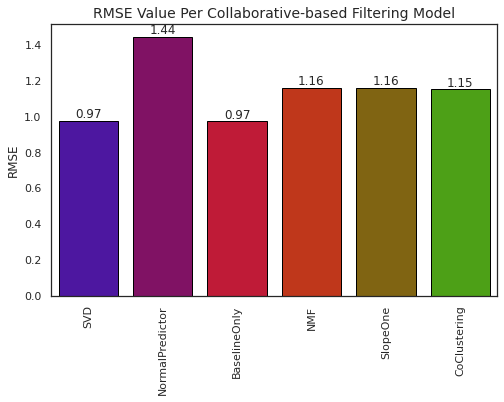

In [87]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','NormalPredictor','BaselineOnly','NMF','SlopeOne','CoClustering']
rmse_y = [svd_rmse,np_rmse,blo_rmse,nmf_rmse,slo_rmse,cc_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='brg',edgecolor='black')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

### Cross Validation

Cross validation is a technique used to test the accuracy of a model's prediction on unseen data (validation sets). This is important because it can assist in picking up issues such as over/underfitting and selection bias. We used the K-fold technique to perform cross validation on our two best perfoming models, i.e. **SVD** and **BaselineOnly**.

**SVD**

In [88]:
svd_test = SVD(n_epochs = 40, n_factors = 200, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svd_test, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9703  0.9754  0.9675  0.9680  0.9602  0.9683  0.0049  
Fit time          18.24   18.20   18.25   18.32   18.30   18.26   0.04    
Test time         0.18    0.18    0.17    0.20    0.17    0.18    0.01    


**BaselineOnly**

In [89]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
b = cross_validate(blo_test, data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9660  0.9592  0.9634  0.9784  0.9712  0.9677  0.0067  
Fit time          2.13    2.09    2.18    2.18    2.20    2.16    0.04    
Test time         0.13    0.13    0.14    0.14    0.13    0.13    0.00    


<a id="analysis"></a>
## 7. Model Analysis

In [90]:
# Load the 100k dataset
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Hyperparameter Tuning 

Hyperparameter tuning is the process by which a set of ideal hyperparameters are chosen for a model. A hyperparameter is a parameter for which the value is set manually and tuned to control the algorithm's learning process. We tested multiple parameters for our best performing model (i.e. **SVD**).

In [91]:
param_grid = {'n_epochs':[40], #[30,40,50],
              'n_factors':[400], #[100,200,300,400],
              'init_std_dev':[0.005], #[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

***Best score:***
0.9676649842296504
***Best parameters:***
{'n_epochs': 40, 'n_factors': 400, 'init_std_dev': 0.005, 'random_state': 42}


### Results

In [92]:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.9734


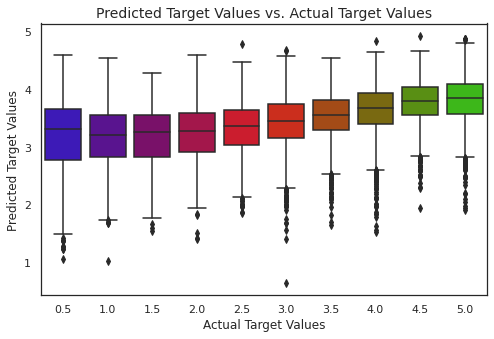

In [93]:
# Predicted Target Values vs. Actual Target Values
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1
true = new_df['rating']
pred = []
for i in predictions:
    pred.append(i.est)
fig,axis = plt.subplots(figsize=(8, 5))
sns.boxplot(x=true, y=pred, palette="brg")
plt.title("Predicted Target Values vs. Actual Target Values", fontsize=14)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.show()

<a id="conclusion"></a>
## 8. Conclusion
The singular value decomposition (SVD) algorithm is a baseline approach to recommender systems, as it has a broad range of applications including dimensionality reduction, solving linear inverse problems, and data fitting. The SVD algorithm generally performs better on large datasets compared to some other models as it decomposes a matrix into constituent arrays of feature vectors corresponding to each row and each column.

<a id="save"></a>
## 9. Save Output

In [ ]:
# Train model on whole dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test_df.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
results.to_csv("submission.csv", index=False)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5


In [ ]:
experiment.log_dataset_hash(trainset)

params = {'n_epochs':40, #[30,40,50],
          'n_factors':400, #[100,200,300],
          'init_std_dev':0.005, #[0.005,0.05,0.1],
          'random_state':[42]} 
metrics = {"RMSE": np.sqrt(mean_squared_error(true, pred))}

experiment.log_parameters(params)
experiment.log_metrics(metrics)
experiment.end()

In [ ]:
from google.colab import files
files.download('submission.csv')

[Back to top ↑](#top)